# Financial Time Series Analysis and Volatility Forecasting Project


-Paolo Bortun 

C:\Users\Paolo\AppData\Local\Temp\ipykernel_14596\895477669.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2hat_store[i]=sigma2hat


-------- RESULT OF THE LAST SIMULATION ----------
TRUE VALUE OF SIGMA: 0.35
ESTIMATED OF sigma2hat: [[0.34681361]]
R^2 Regression = 0.9958
-------------------------------------------------
--------RESULT COEFFICIENT LAST SIMULATION--------
Beta 0:
  True: 1.6923
  Estimated: 1.6920
  t-stat: 908.5287
  CI: [1.6883 - 1.6883]
Beta 1:
  True: 1.8131
  Estimated: 1.8141
  t-stat: 974.1429
  CI: [1.8105 - 1.8105]
Beta 2:
  True: 7.5707
  Estimated: 7.5720
  t-stat: 4065.9412
  CI: [7.5684 - 7.5684]
Beta 3:
  True: 4.5682
  Estimated: 4.5679
  t-stat: 2452.8371
  CI: [4.5643 - 4.5643]
Beta 4:
  True: 1.2125
  Estimated: 1.2121
  t-stat: 650.8617
  CI: [1.2084 - 1.2085]


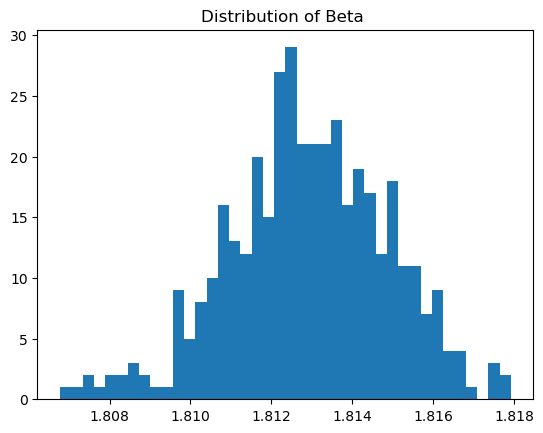

In [1]:
#ESTIMATION BETA TROUGH OLS
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
N=100000 #number of observation
S=400 #number of simulation

sigma2=0.35
k=5

beta_true=10*np.random.rand(k,1) #k rows and 1 column and i multiply for 10 to have uniform distribution between [0,10]
column_1=np.ones((N,1)) #first column of 1
column=np.random.randn(N, k-1) #generate a normal with mean 0 e variance 1 and dimension N * (k-1)

x_matrix=np.hstack((column_1,column)) #put the one column with the other

betaHat_store=np.zeros((k,S)) 
sigma2hat_store=np.zeros(S)

for i in range(S):
    z=np.random.randn(N,1) #vector of N rows e 1 column
    eps=z * np.sqrt(sigma2) #to make the normal with my variance

    y=x_matrix @ beta_true + eps

    #Now i want to compute B_hat=(X'X)^-1 * X'y
    XTX=x_matrix.T @ x_matrix #i compute X' * Y
    XTy=x_matrix.T @ y #I compute X' * Y , x transpose times y

    betaHat=np.linalg.solve(XTX,XTy) #function to solve a linear system, is like that A*x=B and find for x, in our case B hat

    yHat=x_matrix @ betaHat #estimated value of y
    e=y-yHat #residual
    
    RSS=e.T @ e

    sigma2hat= RSS / (N-k)

    

    varBetaHat_matrix=sigma2hat* np.linalg.inv(XTX) #compute variance of beta hat
    varBetaHat = np.diag(varBetaHat_matrix) #take only the diagonal
    stdBetaHat = np.sqrt(varBetaHat) #compute std error

    tstat = betaHat / stdBetaHat #compute the statistics

    R2 = 1 - np.var(e) / np.var(y)#compute R^2

    tcrit = t.ppf(1 - 0.025, N - k)  # 1-0.025 for 95% CI

    betaInt = np.hstack((betaHat - tcrit * stdBetaHat, betaHat + tcrit * stdBetaHat)) #CI interval
    
    betaHat_store[:,i]=betaHat.flatten() #flatten is used to transform the column vector in a array
    sigma2hat_store[i]=sigma2hat

print("-------- RESULT OF THE LAST SIMULATION ----------")
print(f"TRUE VALUE OF SIGMA: {sigma2}")
print(f"ESTIMATED OF sigma2hat: {sigma2hat}")
print(f"R^2 Regression = {R2:.4f}")

print("-------------------------------------------------")

print("--------RESULT COEFFICIENT LAST SIMULATION--------")
for j in range(k):
    print(f"Beta {j}:")
    print(f"  True: {beta_true[j][0]:.4f}") 
    print(f"  Estimated: {betaHat[j][0]:.4f}")
    print(f"  t-stat: {tstat[j][0]:.4f}")
    print(f"  CI: [{betaInt[j, 0]:.4f} - {betaInt[j, 1]:.4f}]")


plt.hist(betaHat_store[1, :], bins=40)

plt.title("Distribution of Beta ")

plt.show()

Dimension of array y: (1000,)


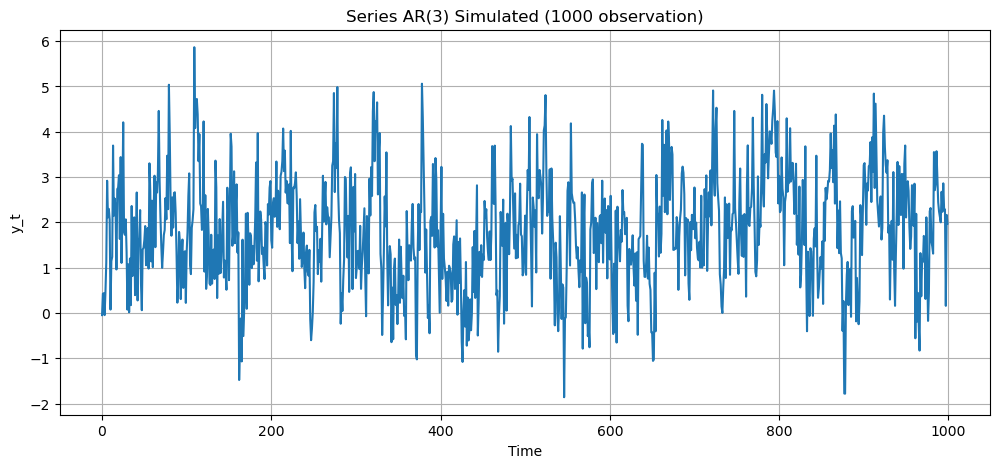

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#OBSERVATION AND SEED 
n_obs_total = 1100
np.random.seed(42)
n_burn_in = 100

#PARAMETER OF THE MODEL
phi_0=0.5
phi_1=0.4
phi_2=0.2
phi_3=0.1
sigma=1.0 

epsilon=np.random.normal(loc=0,scale=sigma,size=n_obs_total) #GENERATE THE ERROR

y=np.zeros(n_obs_total)

for t in range(3,n_obs_total): #i start from 3 and i finish at 1099
    y[t]=phi_0 + phi_1 * y[t-1] + phi_2 * y[t-2] + phi_3 * y[t-3] + epsilon[t]

y_simulated = y[n_burn_in:] # to cut the first 100 simulation
print(f"Dimension of array y: {y_simulated.shape}") #should be 1000 

plt.figure(figsize=(12, 5))
plt.plot(y_simulated)
plt.title("Series AR(3) Simulated (1000 observation)")
plt.xlabel("Time")
plt.ylabel("y_t")
plt.grid(True)
plt.show()


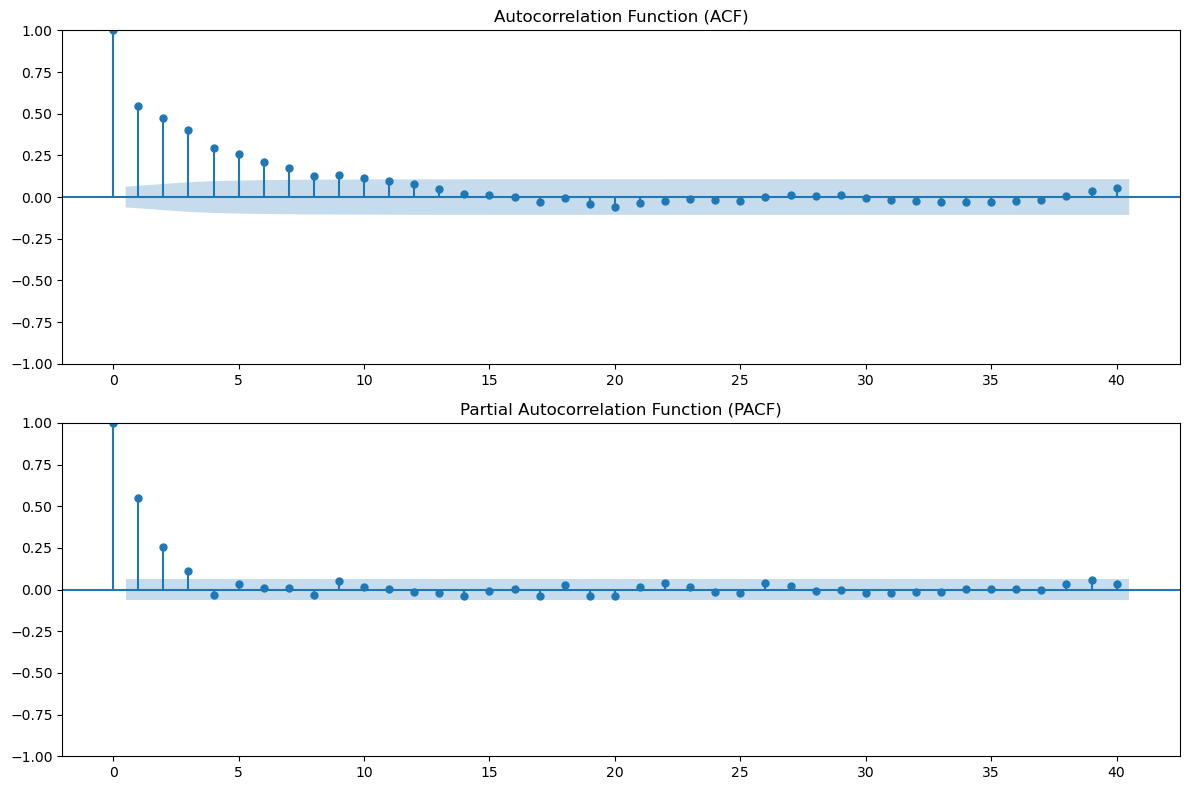

In [3]:
#COMPUTATION OF ACF AND PACF
fig,(ax1,ax2)=plt.subplots(2, 1 , figsize=(12,8))

#GRAPH ACF
plot_acf(y_simulated, lags=40, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")

#GRAPH PACF
plot_pacf(y_simulated, lags=40, ax=ax2, method="ols") 
ax2.set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout() # Sistema gli spazi tra i grafici
plt.show()

#from the graphs is obvious that is a AR(3) process.

In [4]:
#ESTIMATION OF AR(3) WITH OLS
model=AutoReg(y_simulated,lags=3,trend="c") #lags tell that is a model AR(3) and trend tell that we have an intercept
results = model.fit()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1000
Model:                     AutoReg(3)   Log Likelihood               -1397.155
Method:               Conditional MLE   S.D. of innovations              0.983
Date:                Mon, 08 Dec 2025   AIC                           2804.310
Time:                        23:26:30   BIC                           2828.834
Sample:                             3   HQIC                          2813.632
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5524      0.064      8.618      0.000       0.427       0.678
y.L1           0.3817      0.031     12.124      0.000       0.320       0.443
y.L2           0.2071      0.033      6.260      0.0

Parameters estimated: 0.5523872504362286, 0.38170156325988613, 0.20712539465602472, 0.10880995550781954
Forecasts completed
RMSE (True Parameters):     1.1774
RMSE (Estimated parameters): 1.1615


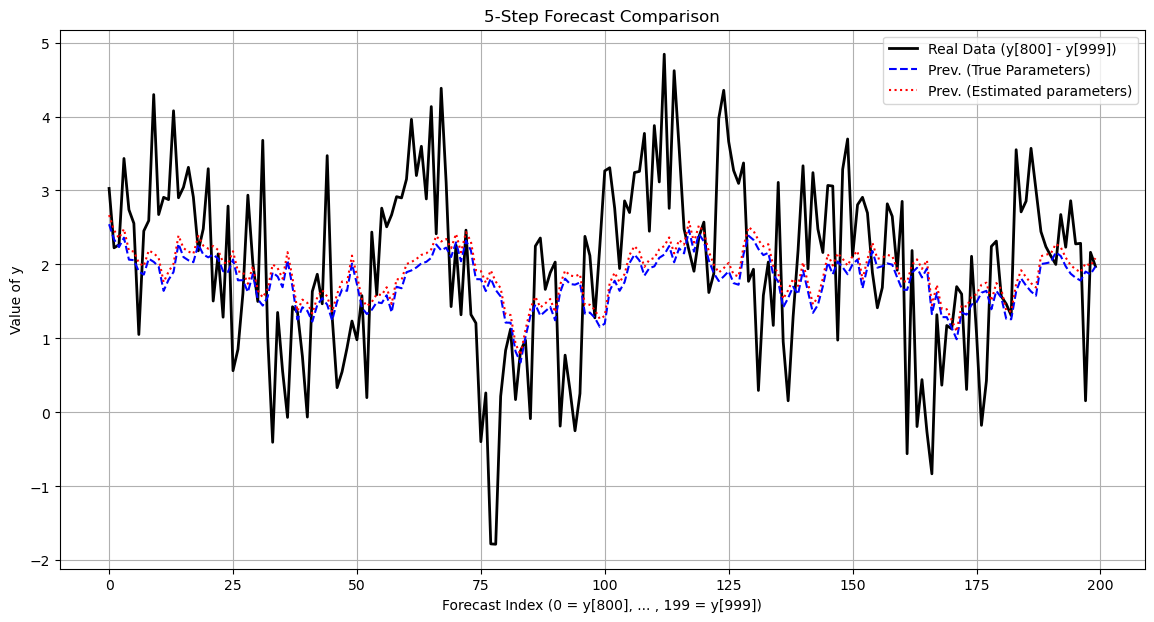

In [5]:
#COMPUTED RMSE AND THE GRAPH OF THE PREDICTION
targets=y_simulated[800:]
forecasts_true_params=[]
forecasts_estimated_params=[]

params_estimated = results.params

phi0_est = params_estimated[0]
phi1_est = params_estimated[1]
phi2_est = params_estimated[2]
phi3_est = params_estimated[3]

print(f"Parameters estimated: {phi0_est}, {phi1_est}, {phi2_est}, {phi3_est}") #to check 

for t in range(795,995):
    history_base = y_simulated[t-2 : t+1] # This take from y[t] to y[t-2] for the forecast since E[y[t+1]]=phi_0 + phi_1 * yt + phi_2 * y[t-1] * phi_3 * y[t-2]
    history_true = list(history_base) # Copy the story

    for h in range(5): #to make prediction with real model
        y_pred_true=phi_0 + (phi_1* history_true[-1]) + (phi_2 * history_true[-2]) + (phi_3 * history_true [-3])

        history_true.append(y_pred_true) #Add the value of the story to make the next prediction 

    forecasts_true_params.append(history_true[-1]) #this take the last value y[t+5] forecast

    history_est = list(history_base) 

    for h in range(5): #to make the prediction with the estimated model
        y_pred_est = phi0_est + \
                     (phi1_est * history_est[-1]) + \
                     (phi2_est * history_est[-2]) + \
                     (phi3_est * history_est[-3])
        
       
        history_est.append(y_pred_est)
        
    forecasts_estimated_params.append(history_est[-1]) #to save only the last forecast y[t+5]

print("Forecasts completed")


#COMPUTE THE RMSE FOR THE BOTH FORECAST
rmse_true = np.sqrt(mean_squared_error(targets, forecasts_true_params))
rmse_est = np.sqrt(mean_squared_error(targets, forecasts_estimated_params))

print(f"RMSE (True Parameters):     {rmse_true:.4f}")
print(f"RMSE (Estimated parameters): {rmse_est:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(range(200), targets, label="Real Data (y[800] - y[999])", color="black", linewidth=2)
plt.plot(range(200), forecasts_true_params, label="Prev. (True Parameters)", color= "blue", linestyle="--")
plt.plot(range(200), forecasts_estimated_params, label="Prev. (Estimated parameters)", color="red", linestyle=":")

plt.title("5-Step Forecast Comparison")
plt.xlabel("Forecast Index (0 = y[800], ... , 199 = y[999])")
plt.ylabel("Value of y")
plt.legend()
plt.grid(True)
plt.show()

All good
True parameter: w=0.1000, alfa=0.1500, beta=0.8000
Estimated parameter: w=0.1570, alfa=0.1897, beta=0.7349



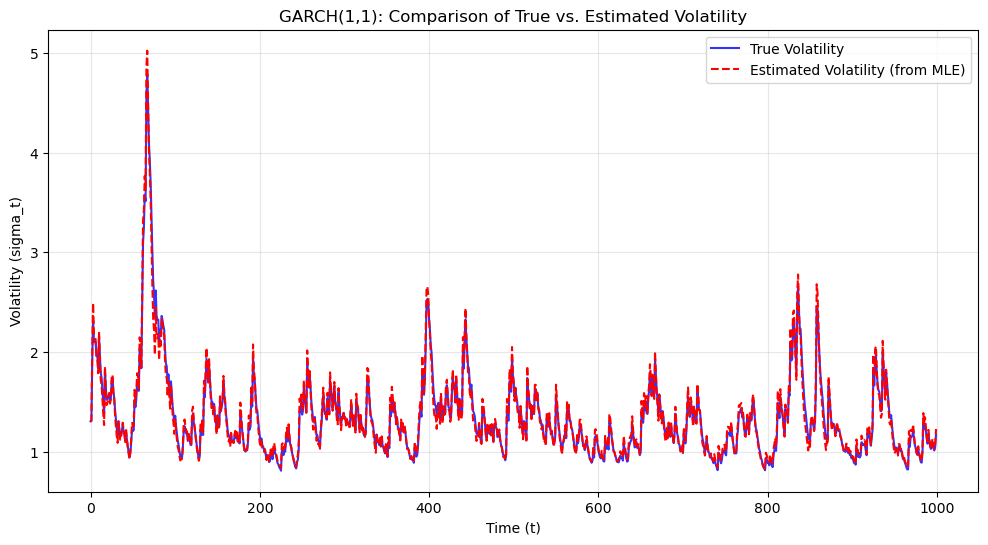

Forecast for the next 5 days: [1.1987873  1.21891221 1.23722842 1.25392549 1.26916813]


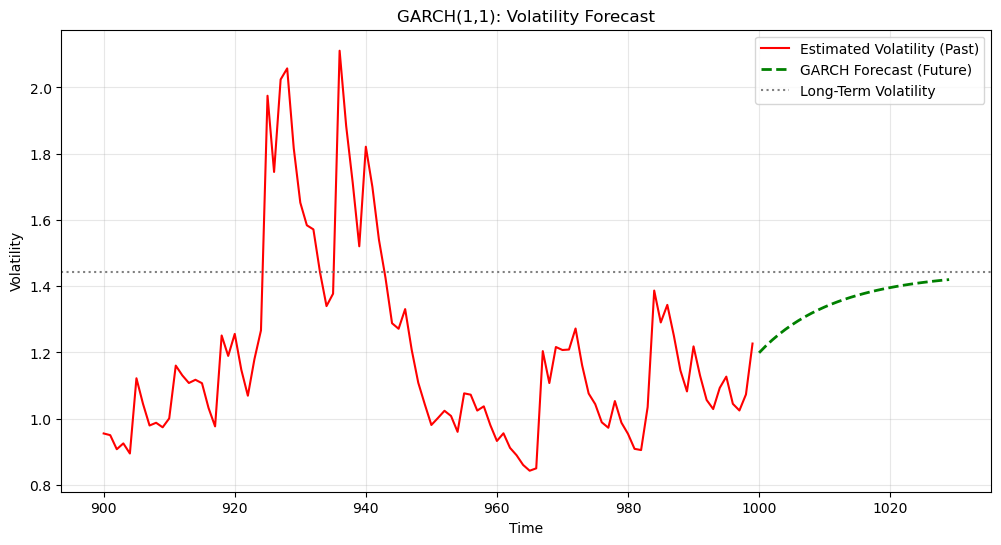

In [6]:
#GARCH(1,1) MODEL 
import numpy as np
from scipy.optimize import minimize

w_true=0.1
alfa_true=0.15
beta_true=0.80 # i should have alfa+beta<1

T=1000

sigma_sq_true=np.zeros(T)
returns_simulated=np.zeros(T)

conditional_variance=(w_true)/(1-alfa_true -beta_true)
sigma_sq_t_minus_1 = conditional_variance #set variance equal conditional variance
r_t_minus_1 = 0.0           #is our (t-1) return

for t in range(T):
    epsilon= np.random.randn()
    variance_model=w_true + alfa_true * r_t_minus_1**2 + beta_true * sigma_sq_t_minus_1

    return_model=epsilon * np.sqrt(variance_model)

    sigma_sq_true[t]=variance_model
    returns_simulated[t] = return_model

    sigma_sq_t_minus_1 = variance_model
    r_t_minus_1 = return_model

# ESTIMATION WITH MLE, I HAVE ONLY THE RETURN THAT I SIMULATED
def garch_log_likelihood(params, data):
    w, alfa, beta= params[0], params[1], params[2]
    T=len(data)

    if(alfa + beta) >=1.0 or w<=0 or alfa<0 or beta<0: #costraint for the parameter for stationarity and also for non negativity of sigma
        return 1e10

    sigma_sq_re=np.zeros(T)

    sigma_sq_t_minus_1=w/ (1 - alfa - beta)
    r_t_minus_1=0.0  #I PUT THE VALUE AT t=0

    for t in range(T):
        sigma_sq_re[t]=w + alfa * r_t_minus_1**2 + beta* sigma_sq_t_minus_1

        sigma_sq_t_minus_1=sigma_sq_re[t] #i upload the value
        r_t_minus_1=data[t] #i use the observed data

    sigma_sq_re[sigma_sq_re<1e-8]=1e-8 #to avoid the division for zero ora to have log(0)

    log_likelihoods= -0.5 * (np.log(2 * np.pi) + np.log(sigma_sq_re) + (data**2/ sigma_sq_re))
    
    return -np.sum(log_likelihoods) #i take the negative since i have to minimize

data_for_estimate=returns_simulated

initial_parameters=[0.1,0.1,0.8] #i try to guess the parameters 

bnds=((1e-6,None),(0.0,None),(0.0,None)) #costraint for parameters


cons=({"type": "ineq", "fun": lambda params: 1.0 - params[1] - params[2]}) #there is costraint with inequality since alfa + beta <1 but python accept only >0 so 1 - alfa - beta >0


result = minimize(garch_log_likelihood, initial_parameters, args=(data_for_estimate,),method='SLSQP', bounds=bnds, constraints=cons) #i use Sequential Least Squares Programming

if result.success:
    estimated_params=result.x
    w_est, alfa_est, beta_est= estimated_params[0], estimated_params[1], estimated_params[2]

    print("All good")
    print(f"True parameter: w={w_true:.4f}, alfa={alfa_true:.4f}, beta={beta_true:.4f}")
    print(f"Estimated parameter: w={w_est:.4f}, alfa={alfa_est:.4f}, beta={beta_est:.4f}\n")
else:
    print("Someting is wrong")



if result.success:
    sigma_sq_estimate=np.zeros(T)

    VL_est = w_est / (1 - alfa_est - beta_est)
    sigma_sq_t_minus_1_est = VL_est
    r_t_minus_1 = 0.0

    for t in range(T):
        sigma_sq_estimate[t]= w_est + alfa_est * (r_t_minus_1**2)   +  beta_est * sigma_sq_t_minus_1_est 

        sigma_sq_t_minus_1_est=sigma_sq_estimate[t]
        r_t_minus_1=data_for_estimate[t]


    
vol_true = np.sqrt(sigma_sq_true)
vol_estimate = np.sqrt(sigma_sq_estimate)
    
plt.figure(figsize=(12, 6))
plt.plot(vol_true, label="True Volatility", color="blue", alpha=0.8)
plt.plot(vol_estimate, label="Estimated Volatility (from MLE)", color="red", linestyle="--")
plt.title("GARCH(1,1): Comparison of True vs. Estimated Volatility")
plt.xlabel("Time (t)")
plt.ylabel("Volatility (sigma_t)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#FORECASTING# 

forecast_horizon = 30 #TIME FOR FORECAST
forecast_variance = np.zeros(forecast_horizon)


last_r = data_for_estimate[-1]          #I TAKE THE LAST DATA FOR THE FORECAST
last_sigma_sq = sigma_sq_estimate[-1]  

forecast_variance[0] = w_est + alfa_est * (last_r**2) + beta_est * last_sigma_sq

# 4. Calcoliamo dal Giorno 2 al Giorno 30
for h in range(1, forecast_horizon):
    previous_forecast = forecast_variance[h-1]  #FOR THE NEXT DAY WE DON'T KNOW THE RETURN, SO I USE THE FORMULA w + (alfa + beta) * sigma_old
    forecast_variance[h] = w_est + (alfa_est + beta_est) * previous_forecast


forecast_volatility = np.sqrt(forecast_variance)

print("Forecast for the next 5 days:", forecast_volatility[:5])



plt.figure(figsize=(12, 6))

plt.plot(range(T-100, T), vol_estimate[-100:], label='Estimated Volatility (Past)', color='red') #i plot the last 100 day of past data

x_future = range(T, T + forecast_horizon)#forecast that go from T to T+30
plt.plot(x_future, forecast_volatility, label='GARCH Forecast (Future)', color='green', linewidth=2, linestyle='--')

long_run_vol = np.sqrt(w_est / (1 - alfa_est - beta_est)) #orrizontal line for the volatility in the long period
plt.axhline(y=long_run_vol, color='gray', linestyle=':', label='Long-Term Volatility')

plt.title("GARCH(1,1): Volatility Forecast")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


       logRV  RV_daily  RV_weekly  RV_monthly    Target
21  2.743588  2.743588   3.044995    2.805371  2.688918
22  2.597235  2.597235   2.961076    2.809778  2.684594
23  2.552843  2.552843   2.825241    2.808628  2.643547
24  2.294606  2.294606   2.700276    2.789208  2.660209
25  2.462027  2.462027   2.530060    2.773804  2.727966
                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2104.
Date:                Mon, 08 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:26:32   Log-Likelihood:                -372.70
No. Observations:                4118   AIC:                             753.4
Df Residuals:                    4114   BIC:                             778.7
Df Model:                       

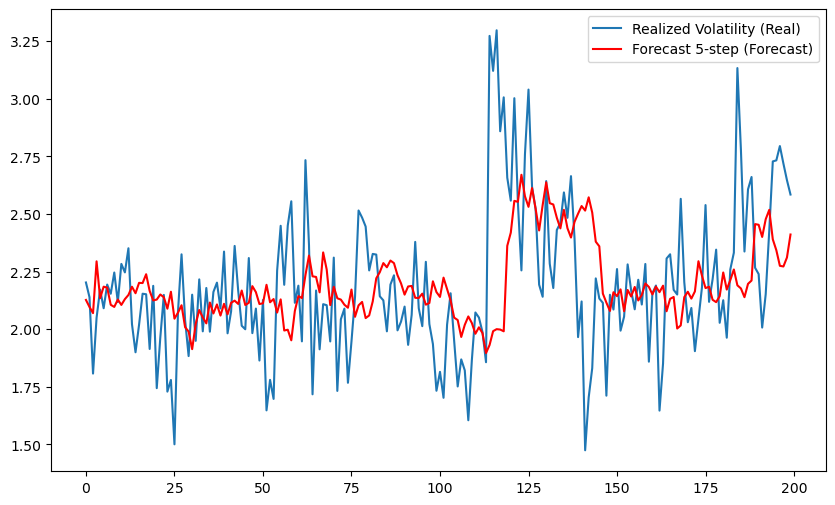

RMSE: 0.32589624227140346


In [7]:
#ESTIMATION OF HAR MODEL
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

df = pd.read_csv('LogRV.txt', header=None, names=['logRV'])

df["RV_daily"]=df["logRV"]

df["RV_weekly"]=df["logRV"].rolling(window=5).mean()

df["RV_monthly"]=df["logRV"].rolling(window=22).mean()

df['Target'] = df['logRV'].shift(-5) #to make the target, since i have to forecast the 5-step ahead

df_clean=df.dropna()

print(df_clean.head())

X=df_clean[["RV_daily", "RV_weekly", "RV_monthly"]]
Y = df_clean['Target']

X=sm.add_constant(X) #i add the costant
test_size=200
X_train=X.iloc[:-test_size] #in practice start from 1 and go to 800 obs
Y_train=Y.iloc[:-test_size]

X_test=X.iloc[-test_size:] #in practice start from 800 and go to the end 1000
Y_test=Y.iloc[-test_size:]

model=sm.OLS(Y_train, X_train).fit()
print(model.summary())



#PREDICTIONS
predictions=model.predict(X_test)


plt.figure(figsize=(10,6))
plt.plot(Y_test.values, label='Realized Volatility (Real)')
plt.plot(predictions.values, label='Forecast 5-step (Forecast)', color='red')
plt.legend()
plt.show()

# 3. RMSE
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f"RMSE: {rmse}")